In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm

print(tf.__version__)
print(jax.__version__)

2024-07-05 02:24:43.418618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 02:24:43.418727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 02:24:43.548726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
0.4.23


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? False


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_TFREC = "/kaggle/input/leap-train-tfrecords"

In [5]:
sample = pl.read_csv(os.path.join(DATA, "sample_submission.csv"), n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets']

In [7]:
train_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100)]
valid_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100, 101)]

In [8]:
BATCH_SIZE = 4096

train_options = tf.data.Options()
train_options.deterministic = True

ds_train = (
    tf.data.Dataset.from_tensor_slices(train_files)
    .with_options(train_options)
    .shuffle(100)
    .interleave(
        lambda file: tf.data.TFRecordDataset(file).map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE),
        num_parallel_calls=tf.data.AUTOTUNE,
        cycle_length=10,
        block_length=1000,
        deterministic=True
    )
    .shuffle(4 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

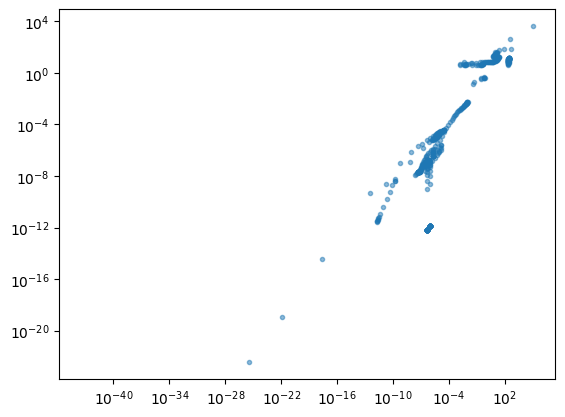

In [9]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(20 if is_interactive() else 1000))

plt.scatter(
    norm_x.mean.squeeze(),
    norm_x.variance.squeeze() ** 0.5,
    marker=".",
    alpha=0.5
)
plt.xscale('log')
plt.yscale('log')

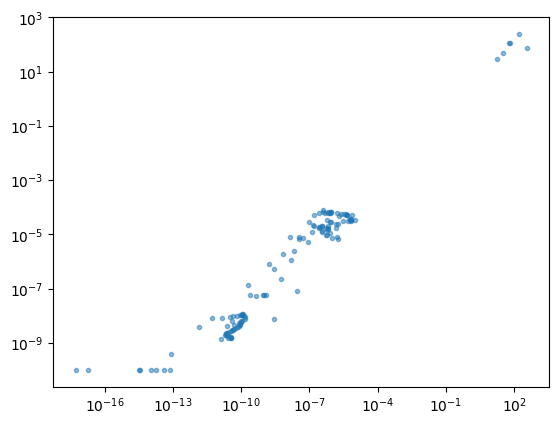

In [10]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(20 if is_interactive() else 1000))

mean_y = norm_y.mean
stdd_y = keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

plt.scatter(
    mean_y.squeeze(),
    stdd_y.squeeze(),
    marker=".",
    alpha=0.5
)
plt.xscale('log')
plt.yscale('log')


In [11]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)

### Model definition & Training

In [12]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

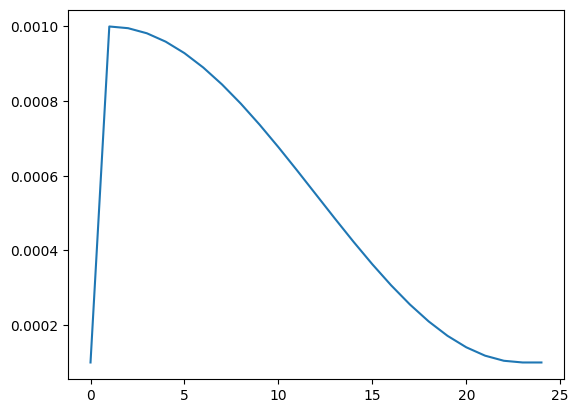

In [13]:
epochs = 25  # 15  # 12
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    1e-4, 
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

plt.plot([lr_scheduler(it) for it in range(0, epochs * steps_per_epoch, steps_per_epoch)]);

In [14]:
keras.utils.clear_session()


def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)


def build_cnn(activation='relu'):
    return keras.Sequential([
        keras.layers.Conv1D(512, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(256, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation=activation),
    ])



X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:])
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x = x_to_seq(x)


e = e0 = keras.layers.Conv1D(64, 1, padding='same')(x)
e = build_cnn()(e)
# add global average to allow some comunication between all levels even in a small CNN
e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e)


p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 360

p_flat = p_all[:, :, 6:6 + 8]
p_flat = keras.ops.mean(p_flat, axis=1)
assert p_flat.shape[-1] == 8

P = keras.ops.concatenate([p_seq, p_flat], axis=1)

# build & compile
model = keras.Model(X_input, P)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=[ClippedR2Score()]
)
model.build(tuple(ds_train.element_spec[0].shape))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 64)    │      1,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 64)    │    615,232 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 64)    │          0 │ conv1d[0][0],     │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 64)     │          0 │ sequential[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 64)    │        256 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,233,294 (4.70 MB)

 Trainable params: 1,229,582 (4.69 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [15]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='model.keras')
    ]
)

Epoch 1/25


2024-07-05 02:30:11.753514: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[4096,512,60]{2,1,0}, u8[0]{0}) custom-call(f32[4096,256,60]{2,1,0}, f32[256,512,3]{2,1,0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-05 02:30:15.809119: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.055788271s
Trying algorithm eng0{} for conv (f32[4096,512,60]{2,1,0}, u8[0]{0}) custom-call(f32[4096,256,60]{2,1,0}, f32[256,512,3]{2,1,0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-05 02:30:17.223568: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying a

2442/2442 - 1148s - 470ms/step - loss: 0.5135 - r2_score: nan - val_loss: 0.3553 - val_r2_score: nan
Epoch 2/25
2442/2442 - 1108s - 454ms/step - loss: 0.3731 - r2_score: nan - val_loss: 0.3078 - val_r2_score: nan
Epoch 3/25
2442/2442 - 1107s - 453ms/step - loss: 0.3416 - r2_score: nan - val_loss: 0.2963 - val_r2_score: nan
Epoch 4/25
2442/2442 - 1108s - 454ms/step - loss: 0.3338 - r2_score: nan - val_loss: 0.2857 - val_r2_score: nan
Epoch 5/25
2442/2442 - 1108s - 454ms/step - loss: 0.3184 - r2_score: nan - val_loss: 0.2700 - val_r2_score: nan
Epoch 6/25
2442/2442 - 1109s - 454ms/step - loss: 0.3062 - r2_score: nan - val_loss: 0.2819 - val_r2_score: nan
Epoch 7/25
2442/2442 - 1109s - 454ms/step - loss: 0.3020 - r2_score: nan - val_loss: 0.2708 - val_r2_score: nan
Epoch 8/25
2442/2442 - 1105s - 453ms/step - loss: 0.2954 - r2_score: nan - val_loss: 0.2588 - val_r2_score: nan
Epoch 9/25
2442/2442 - 1107s - 453ms/step - loss: 0.2908 - r2_score: nan - val_loss: 0.2495 - val_r2_score: nan
Epo

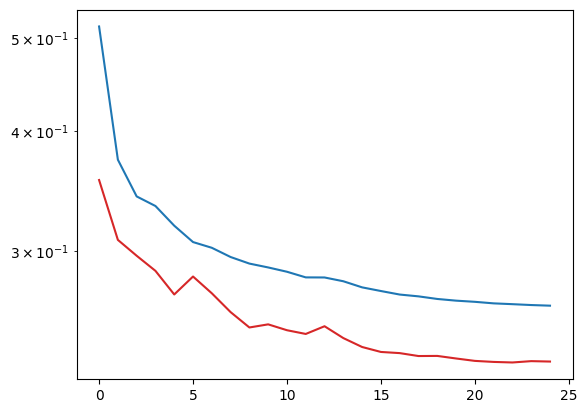

In [16]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.yscale('log');

In [17]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step


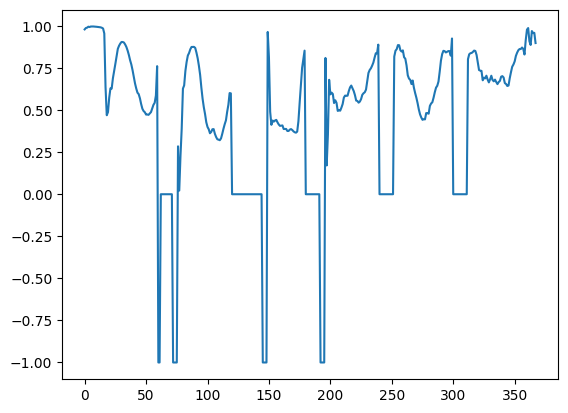

In [18]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

In [19]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

'Number of under-performing targets: 85'

In [20]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

'Clipped score: 0.5106649593073754'

In [21]:
del y_valid, p_valid
gc.collect();

# Submission

In [22]:
sample = pl.read_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv")

In [23]:
df_test = (
    pl.scan_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv")
    .select(pl.exclude("sample_id"))
    .cast(pl.Float32)
    .collect()
)

In [24]:
p_test = model.predict(df_test.to_numpy(), batch_size=4 * BATCH_SIZE) * stdd_y + mean_y
p_test = np.array(p_test)
p_test[:, mask] = mean_y[:, mask]

39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 436ms/step


In [25]:
# correction of ptend_q0002 targets (from 12 to 29)
df_p_test = pd.DataFrame(p_test, columns=TARGETS)

for idx in range(12, 30):
    df_p_test[f"ptend_q0002_{idx}"] = -df_test[f"state_q0002_{idx}"].to_numpy() / 1200
    
p_test = df_p_test.values

In [26]:
submission = sample.to_pandas()
submission[TARGETS] = submission[TARGETS] * p_test
pl.from_pandas(submission[["sample_id"] + TARGETS]).write_csv("submission.csv")